In [69]:
import warnings

# Suppress UserWarnings from the 'mrinufft' module
warnings.filterwarnings("ignore", category=UserWarning, module="mrinufft")

from data import get_data
from kspace_sampling import get_samples, initialize_2D_cartesian
from physic import corrupt, corrupt_coils
from model import get_model, FISTA
from plots import plot_rec, plot_img, plot_images_coils
from mrinufft.trajectories.display import display_2D_trajectory
from physic import Nufft

from data import get_images_coils, to_complex_tensor
from fastmri.data.transforms import to_tensor, complex_center_crop, normalize_instance, normalize
from utils import stand, Clip

import numpy as np
import matplotlib.pyplot as plt
import torch
import fastmri 
import cv2
from skimage.metrics import structural_similarity as ssim
import pdb
from metrics import compute_ssim

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiements Scenario 1 

In [4]:
# samples_loc = get_sparkling()
choice = 3
traj = ['sparkling', 'cartesian', 'radial', 'spiral', 'cones', 'sinusoide', 'propeller', 'rings', 'rosette', 'polar_lissajous', 'lissajous', 'waves']


samples_loc = get_samples(traj[choice], Nc = 50, Ns = 1000)
physic = Nufft((320,320), samples_loc, density='voronoi', real=False, Smaps = None)
# physic = Nufft((320,320), samples_loc, density=None, real=False, Smaps = None)

# display_2D_trajectory(samples_loc)

In [5]:
target_torch, images, y, y_hat, Smaps, mask = get_data(idx = 0, Smaps = True, physics = physic)
mask = mask.squeeze(0)

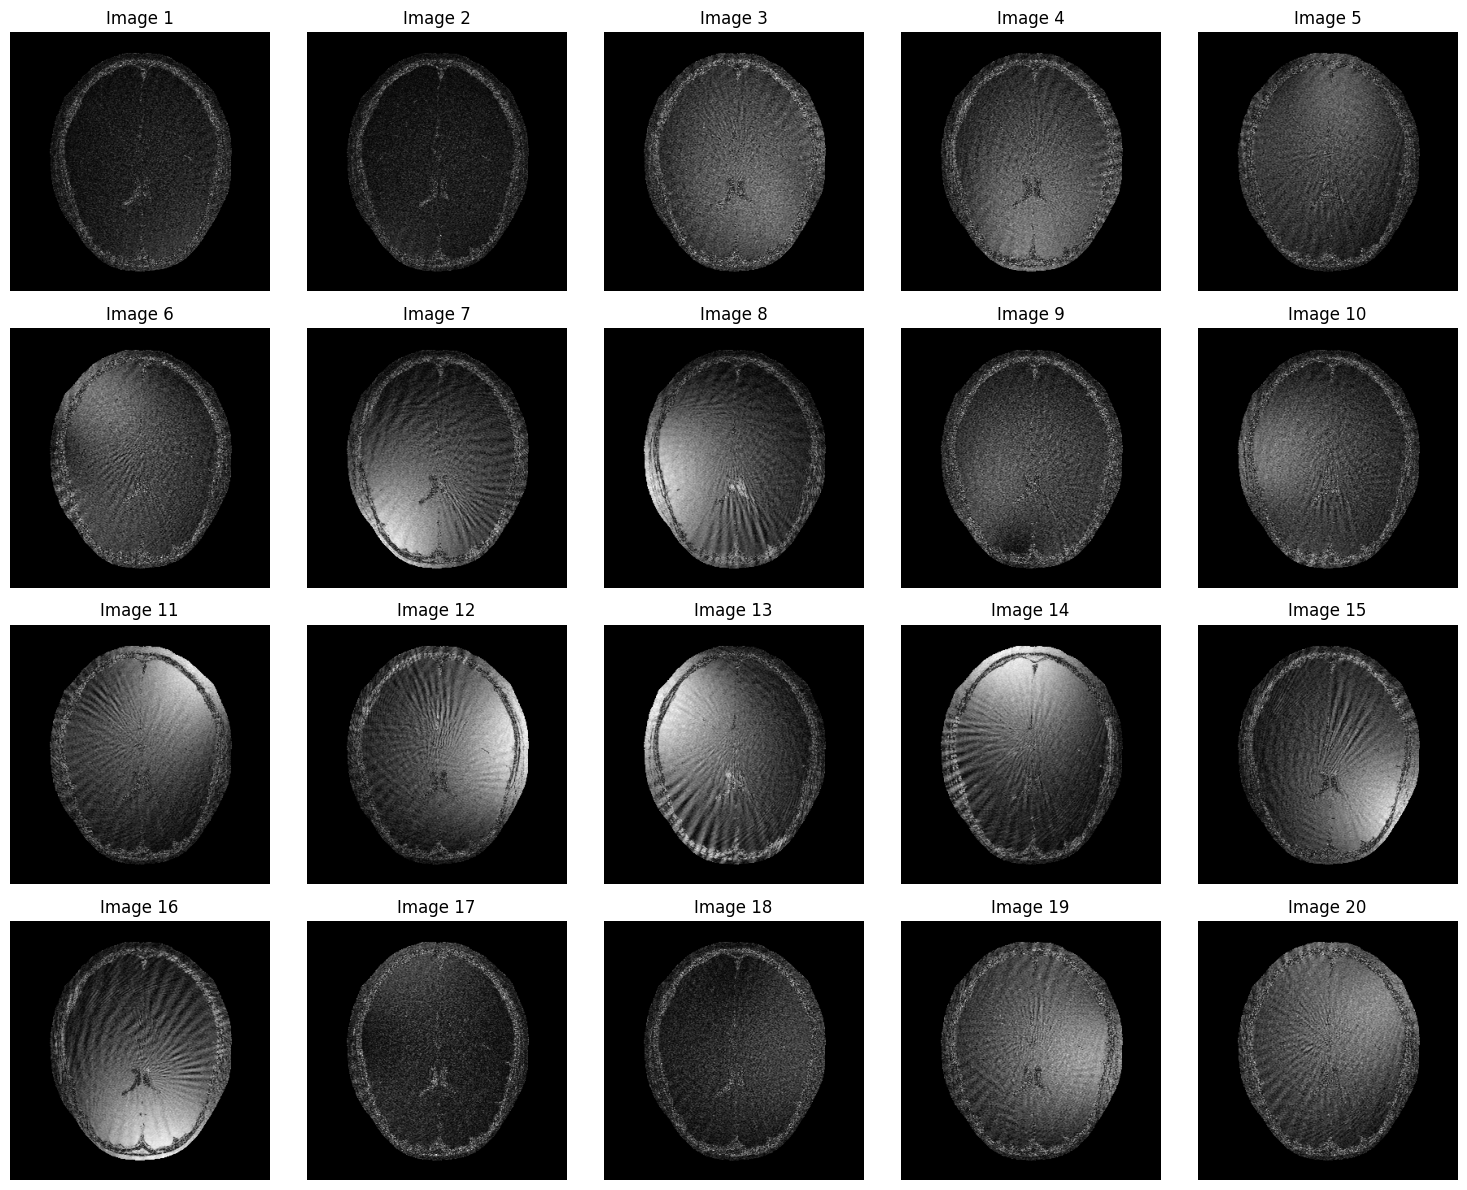

In [7]:
plot_images_coils(to_tensor(Smaps))

In [6]:
physic = Nufft((320,320), samples_loc, density='voronoi', real=False, Smaps = Smaps.squeeze(0).numpy())

In [6]:
algo = get_model(max_iter = 2, sigma = 0.01)

In [7]:
with torch.no_grad():
    x_hat = algo(torch.cat(y_hat, dim = 0).unsqueeze(0), physic)

100%|██████████| 2/2 [00:42<00:00, 21.04s/it]


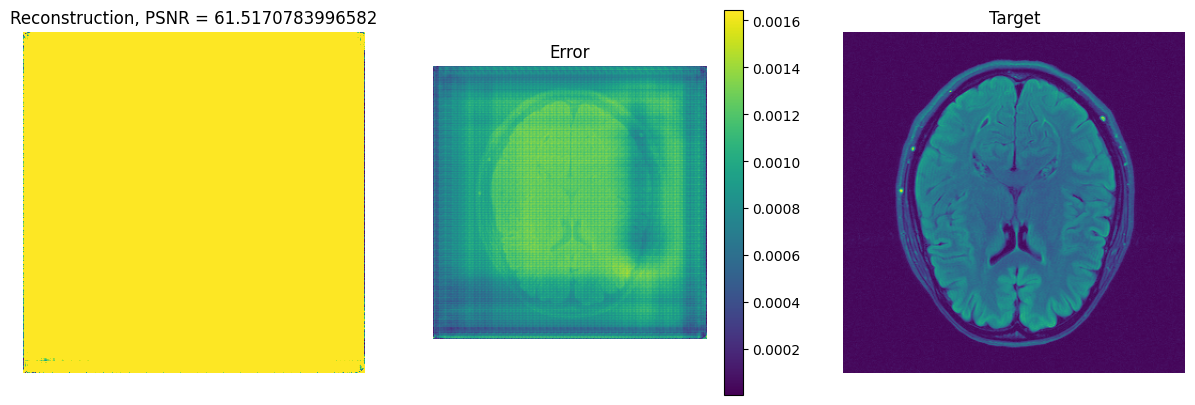

In [8]:
plot_rec(target_torch.squeeze(0), x_hat)

In [9]:
x_hat_fista = FISTA(target_torch.unsqueeze(0), physic, stepsize = 0.00000000001, max_iter = 100, to_stand = True)

Iteration 99, criterion = 0.0005: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


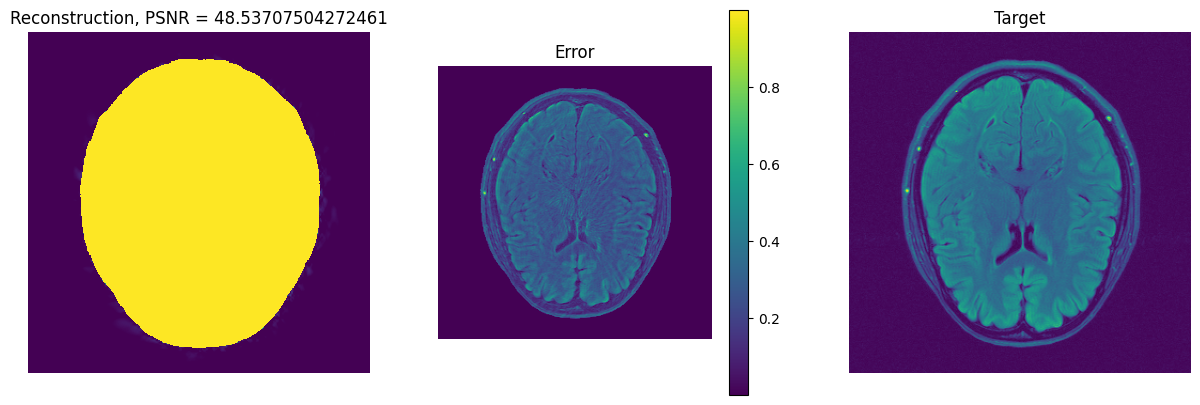

In [10]:
plot_rec(target_torch.squeeze(0), x_hat_fista)

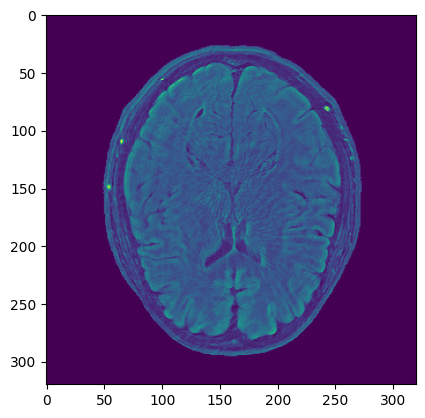

In [17]:
plt.imshow(x_hat_fista[0,0].abs())

In [ ]:
####

# Programme du jour, voir les smaps et pourquoi elles ne sont pas en norme égales à 1e et ensuite écrire un code

### Résolution du problème inverse en utilisant un kspace Y target produit avec le même opérateur que celui utilisé pour trouver la solution x

In [17]:
algo = get_model(max_iter = 30, sigma = 0.005)

5

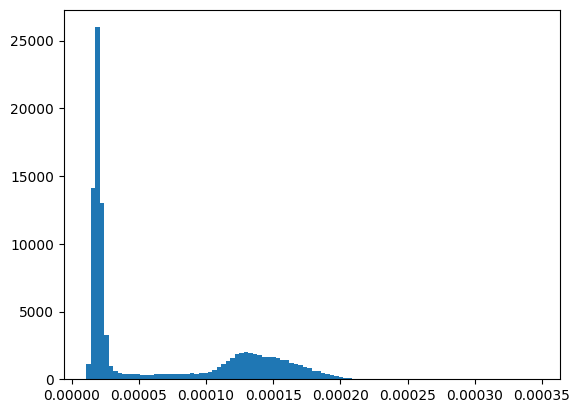

In [12]:
plt.hist(target_torch.reshape(-1), bins = 100)
5

5

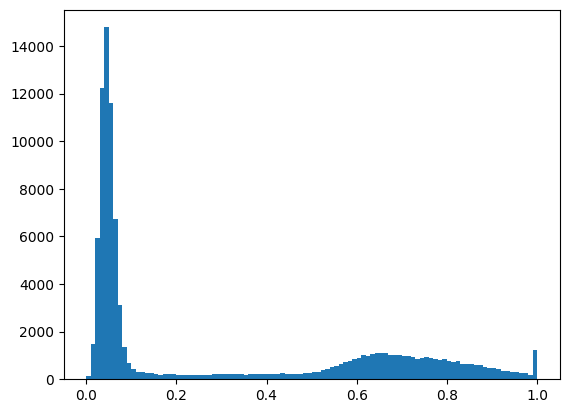

In [8]:
### a voir l'impact de la normalisation dans [0,1] sur le kspace, mais c'est ce qu'on va faire avec la target image pour produire le 
### le kspace target y 

target = stand(target_torch.squeeze(0), clip = (-np.inf, np.quantile(target_torch.squeeze(0).reshape(-1).numpy(), 0.99)))
plt.hist(target.reshape(-1), bins = 100)
5

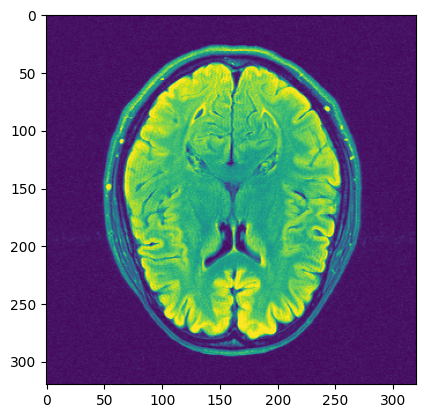

In [13]:
plt.imshow(target)

In [12]:
Y = physic.A(target)

In [18]:
with torch.no_grad():
    x_hat = algo(Y, physic)

100%|██████████| 30/30 [10:51<00:00, 21.72s/it]


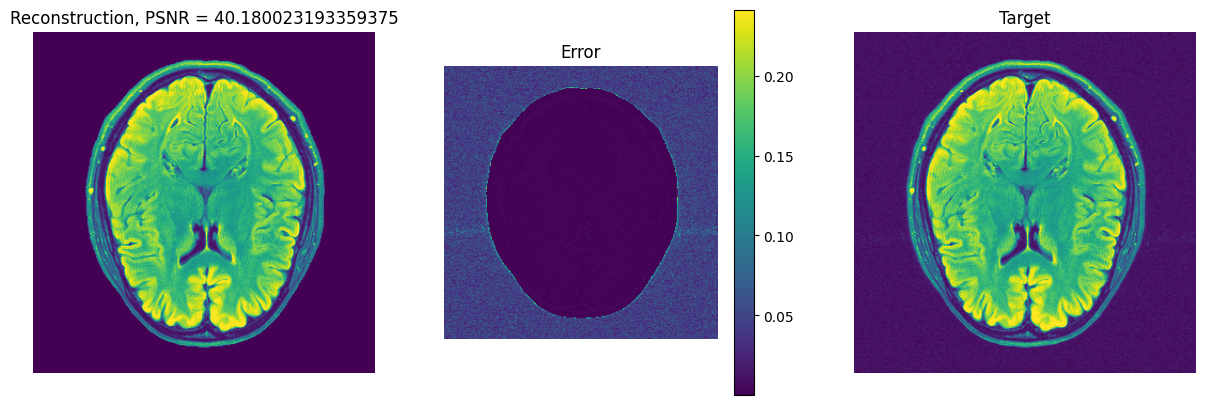

In [19]:
plot_rec(target, x_hat)
### hypothesis: if the noise does not count in the kspace sampling, well our reconstruction should not converge to a noisy image
### especially if the prior on x penalizes a noisy image

In [60]:
mask.shape

torch.Size([320])

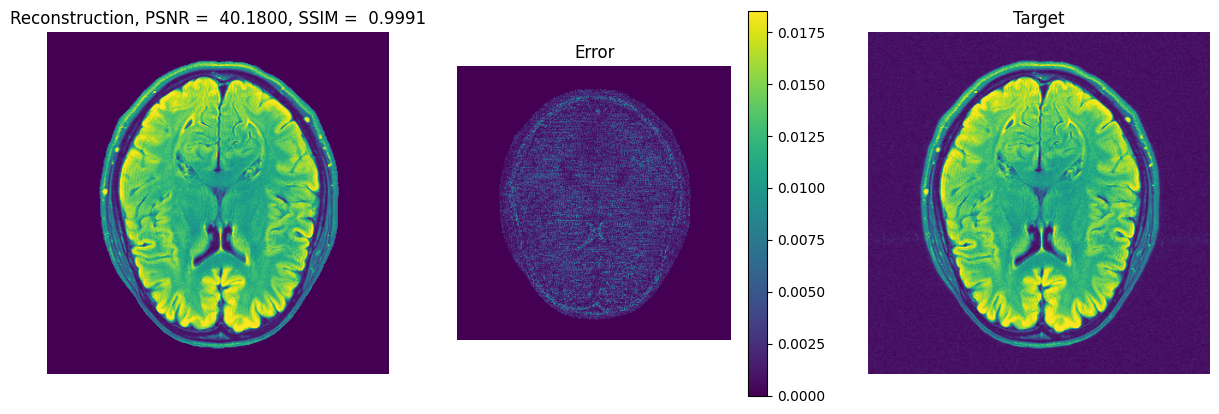

In [20]:
plot_rec(target, x_hat, mask, err_with_mask = True)
### hypothesis: if the noise does not count in the kspace sampling, well our reconstruction should not converge to a noisy image
### especially if the prior on x penalizes a noisy image

In [37]:
compute_ssim(target*mask, x_hat.abs()*mask)

0.9222504576680619

In [35]:
### on check bien que en faisant la résolution de ce problème inverse, on obtient bien une image qui est quasi réel, ce qui
### est cohérent avec le fait que notre target à partir de laquelle on a extrait les kspace était une image réelle

torch.imag(x_hat).mean(), torch.imag(x_hat).max(), torch.real(x_hat).mean(), torch.real(x_hat).min()

(tensor(-0.0003), tensor(0.0005), tensor(0.2801), tensor(-0.0090))

In [9]:
x_hat_fista = FISTA(target, physic, stepsize = 0.000001, max_iter = 100, to_stand = False)

Iteration 99, criterion = 0.0614: 100%|██████████| 100/100 [00:45<00:00,  2.17it/s]


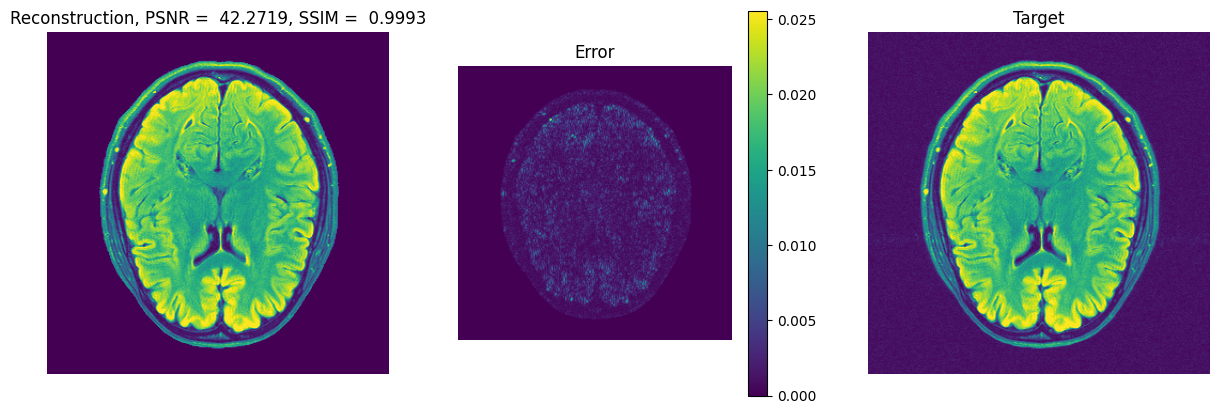

In [10]:
plot_rec(target, x_hat_fista, mask, err_with_mask = True)


# Experiments Scenario 2 

In [2]:
# samples_loc = get_sparkling()
choice = 3
traj = ['sparkling', 'cartesian', 'radial', 'spiral', 'cones', 'sinusoide', 'propeller', 'rings', 'rosette', 'polar_lissajous', 'lissajous', 'waves']


samples_loc = get_samples(traj[choice], Nc = 50, Ns = 1000)
physic = Nufft((320,320), samples_loc, density='voronoi', real=False, Smaps = None)
# physic = Nufft((320,320), samples_loc, density=None, real=False, Smaps = None)

# display_2D_trajectory(samples_loc)

In [85]:
target_torch, images, y, y_hat, Smaps, mask = get_data(idx = 0, Smaps = True, physics = physic)
mask = mask.squeeze(0)

In [6]:
target = stand(target_torch.squeeze(0), clip = (-np.inf, np.quantile(target_torch.squeeze(0).reshape(-1).numpy(), 0.99)))

In [9]:
kspace_voronoi = physic.A(target)

In [10]:
physic_novoro = Nufft((320,320), samples_loc, density=None, real=False, Smaps = None)
kspace_novoro = physic.A(target)


In [13]:
kspace_voronoi.abs().mean(), kspace_novoro.abs().mean()

(tensor(0.4388), tensor(0.4388))

In [14]:
kspace_voronoi.abs().max(), kspace_novoro.abs().max()

(tensor(48.9296), tensor(48.9296))

In [15]:
back_voronoi = physic.A_adjoint(kspace_voronoi)
back_novoro = physic_novoro.A_adjoint(kspace_novoro)

In [16]:
back_voronoi.mean(), back_novoro.mean()

(tensor(18481.3750-0.0003j), tensor(14.3035+1.4599e-07j))

In [52]:
test = back_voronoi.numpy()

In [61]:
test.real[...,0].shape

(1, 1, 320)

Conclusion: the resulting kspace when applying voronoi or not is the same. However, the differences come from when applying the reverse physic problem to obtain the reconstructed image. Therefore, it should not really matter if we use a density correcter or not when solving the inverse problem, only if we take as initialization the reconstructed image. 

In [29]:
torch.stack(y_hat, dim=1).mean()

tensor(-8.1065e-07-1.4448e-07j)

In [33]:
images.shape

torch.Size([1, 20, 320, 320, 2])

5

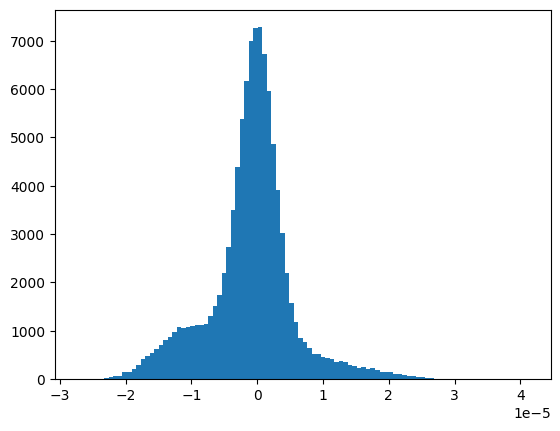

In [65]:
i = 4
plt.hist(images[0,i,:,:,0].reshape(-1), bins = 100)
5

In [67]:
torch.quantile(images[...,0], 0.01), torch.quantile(images[...,0], 0.99)

(tensor(-5.3246e-05), tensor(4.1273e-05))

In [68]:
torch.quantile(images[...,1], 0.01), torch.quantile(images[...,1], 0.99)

(tensor(-4.4404e-05), tensor(4.8678e-05))

5

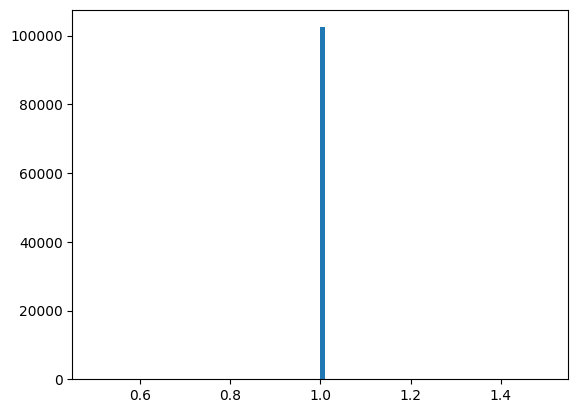

In [84]:
i = 4 
plt.hist(images[0,i,:,:,1].reshape(-1), bins = 100)
5

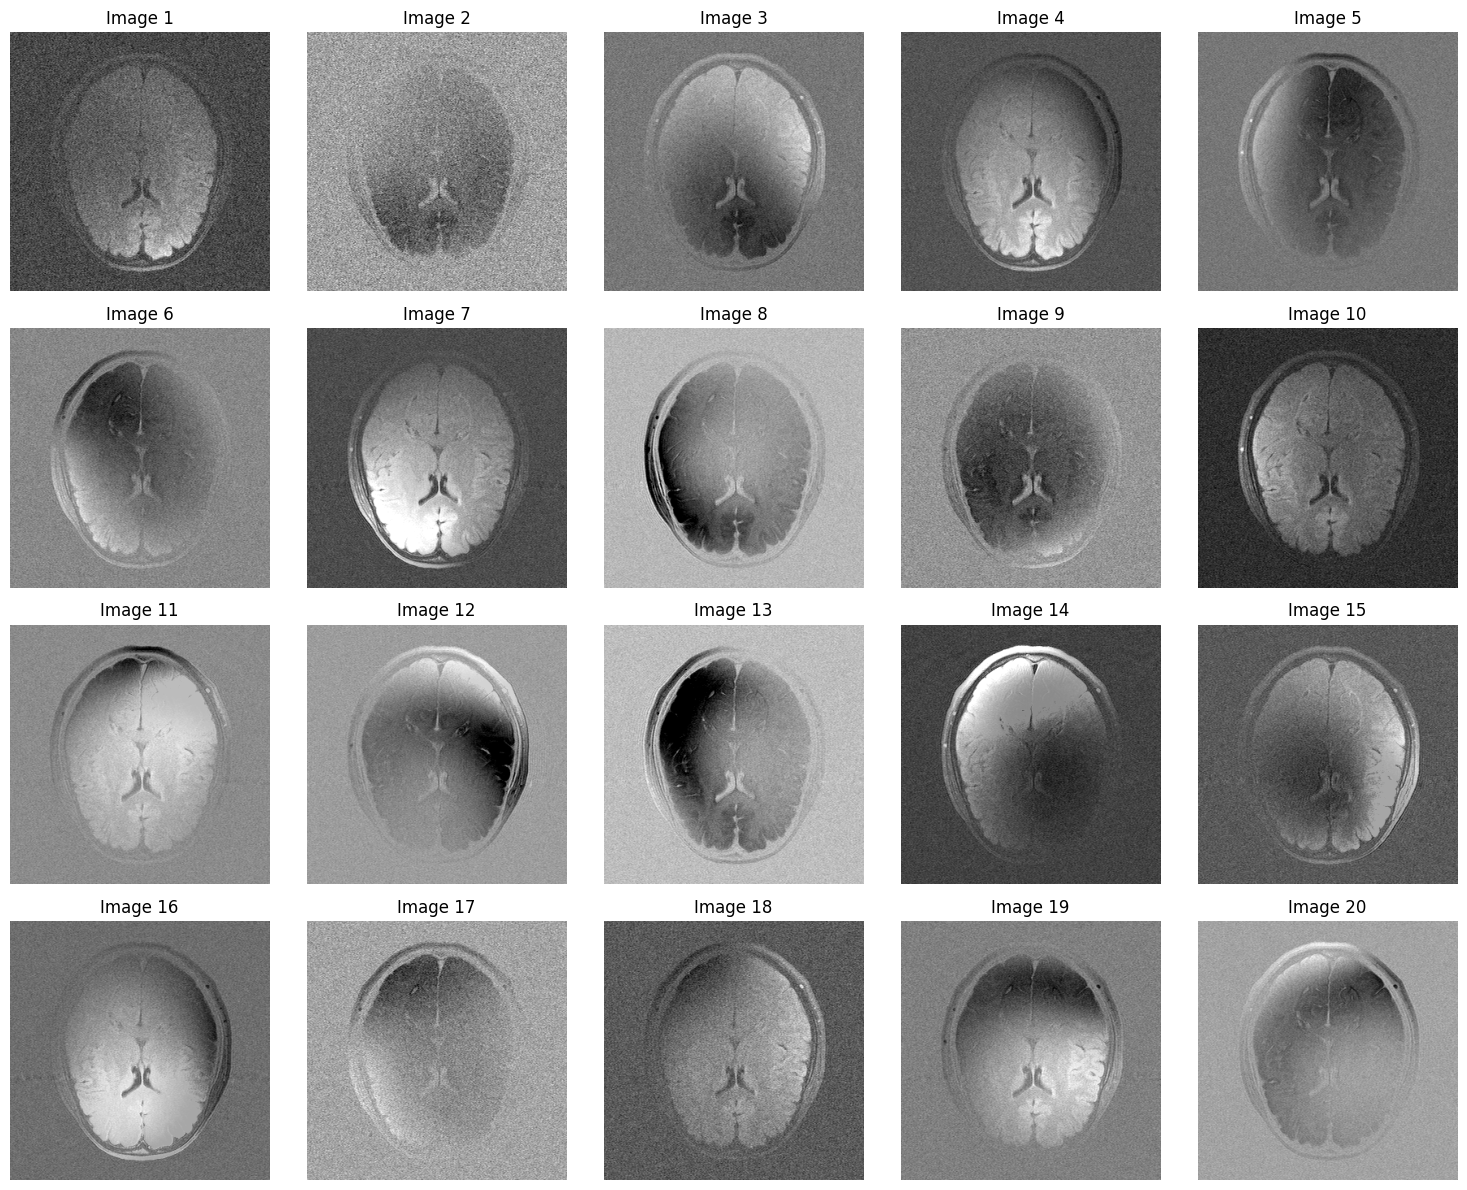

In [91]:
plot_images_coils(images_stand)

In [87]:
clip = Clip()
clip.quantile(images, 0.99)

In [89]:
images_stand = stand(images, clip)

In [82]:
clip.real

(tensor(-5.3246e-05), tensor(4.1273e-05))

5

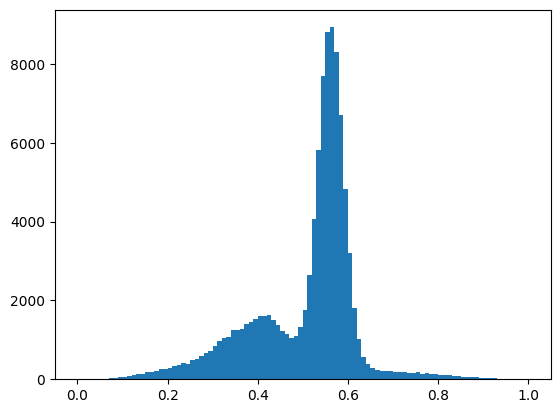

In [90]:
i = 19
plt.hist(images_stand[0,i,:,:,0].reshape(-1), bins = 100)
5

In [79]:
images_stand[0,i,:,:,0]

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])